# Exercise3: Sensors and Sensor Data

*8 points*

In this exercise you will work with laser sensors, divided into two key parts.

- In the first part, you will learn how to process data collected from real-world laser sensors. This includes understanding the raw data, implementing preprocessing techniques, and visualizations.

- The second part focuses on utilizing laser sensor data in a simulated environment. You will explore how to use the data to control a robot's actions, such as navigation, obstacle avoidance, and path planning, within Gazebo simulator.

## Part1: LaserScan Data

Under the same folder of this notebook, you can find a folder named "laserscan". This is a record of the data published by the LIDAR sensor. It records message from topics `/scan`, `/scan_raw` and `/tf`. 

### 1.1 Get the information of the data recording

> Info: The code start with `!` is a bash command.

In [ ]:
!ros2 bag info laserscan

### 1.2 Play data recording

The last commamd only shows the metadata of the data bag file.

To fetch the sensor data we need to replay the bag file, run the following command in a `Terminal` to play the bagfile in a loop.

```bash
ros2 bag play -l laserscan
```

<button data-commandlinker-command="terminal:create-new" data-commandlinker-args='{"cwd": "03_sensors/"}' class="jupyter-button">Open a Terminal</button>

> Hint: You can arrange the tabs by draging them.

### 1.3 Check ROS topic

With the bagfile playing, you can check the overall information of laser scanner topic `/scan`.

In [ ]:
!ros2 topic info /scan

### 1.4 Check the scan data

The topic `/scan` publishes a laser scan message of type `sensor_msgs/LaserScan`. 

Fetch one `sensor_msgs/LaserScan` message.

In [ ]:
!ros2 topic echo /scan --once

### 1.5 Explanation of the data

The header indicates that the scan is with respect to the `/laser` frame.

```yaml
header:
  stamp:
    sec: 1699884688
    nanosec: 646775842
  frame_id: laser
```

The angle min and max tell the range in radians.

```yaml
  angle_min: -2.356194496154785
  angle_max: 2.356194496154785
  angle_increment: 0.004363323096185923
```

In [ ]:
import math
radian = 2.356194496154785
print(f"Radian {radian} in degrees is {math.degrees(radian)}")

As you can see in the following illustration the scan goes from -135 to +135 degrees.

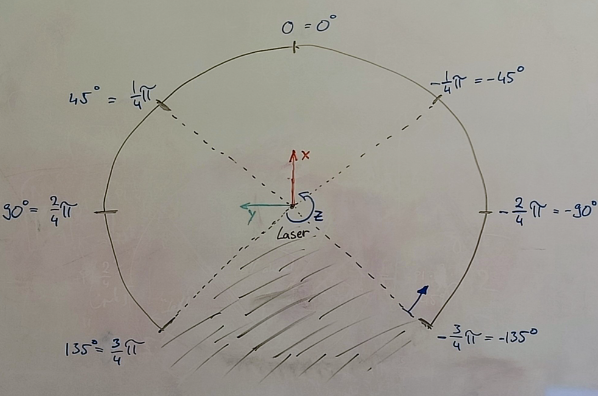

The `angle_increment` defines at what rotational distance the datapoints increment.

```yaml
angle_increment: 0.004363323096185923
```

In [ ]:
math.degrees(0.004363323096185923)

An angle of 1/4 degree means there are 4 datapoints per degree, so there are 4 x 270 datapoints in total.

The time fields is irrelevant, the range indicates the maximum and minimum distance from the laser.

```yaml
time_increment: 1.736111516947858e-05
scan_time: 0.02500000037252903
range_min: 0.019999999552965164
range_max: 30.0
```

**The `ranges` ( 4 x 270 datapoints as distance in meter) are the main data you will be working with. Intensities can be ignored.**

```yaml
ranges:
- 1.2029999494552612
- 1.2059999704360962
- 1.218000054359436
- 1.2059999704360962
- 1.2059999704360962
- 1.2100000381469727
- '...'
intensities:
- 1105.0
- 1099.0
- 1102.0
- '...'
```

### 1.6 Visualization in Rviz

[Rviz](https://docs.ros.org/en/humble/Tutorials/Intermediate/RViz/RViz-User-Guide/RViz-User-Guide.html) is a 3D visualizer for the Robot Operating System (ROS) framework.

Run the follow code to open a virtual desktop environment, you should see a right-side panel popup.

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import utils

utils.display_desktop()

And then launch the Rviz in a new terminal:

```bash
rviz2 -d scan.rviz
```

<button data-commandlinker-command="terminal:create-new" data-commandlinker-args='{"cwd": "03_sensors/"}' class="jupyter-button">Open a Terminal</button>

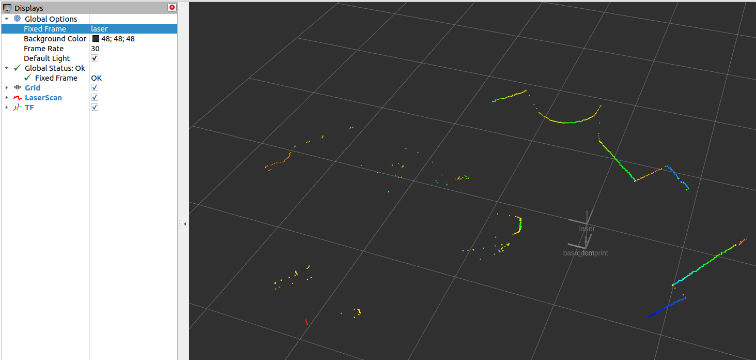

### 1.7 Fetch and process data with Python

From the previous steps we only inspected and visualized the Laserscan data with ROS commands. To process the data further, we need to fetch them with python code. In ROS, fetching data from messages is done through subscribing to topics with the [rclpy](https://github.com/ros2/rclpy) client library.

In [ ]:
import rclpy
from rclpy.node import Node
from sensor_msgs.msg import LaserScan
import numpy as np

# Init the rclpy client
if not rclpy.ok():
    rclpy.init(args=None)

# Node fetches laserscan sensor data only once
class OneShotLaserScanSubscriber(Node):
    def __init__(self):
        super().__init__('laser_scan_subscriber')
        # Create a subscriber to the LaserScan topic
        self.subscription = self.create_subscription(
            LaserScan,
            '/scan',
            self.listener_callback,
            10  # QoS profile depth
        )
        self.data = {}

    def listener_callback(self, msg):
        self.data = msg
        # Since we only want to receive the data once, interrupt the subscription
        raise KeyboardInterrupt

# Wrap up the subscription
def fetch_scan_data():
    # Create an instance of the subscriber node
    one_shot_scan = OneShotLaserScanSubscriber()
    # Spin the node so it can listen to the incoming message
    try:
        rclpy.spin(one_shot_scan)
    except KeyboardInterrupt:
        pass
        
    # Store data to a variable before the cleanup
    scan_data = one_shot_scan.data
    
    # Cleanup the subscription and the ROS node
    one_shot_scan.subscription.destroy()
    one_shot_scan.destroy_node()
    return scan_data

scan_data = fetch_scan_data()
scan_data

Visualize data with matplot

In [ ]:
# Example of how to plot the data
import numpy as np
import matplotlib.pyplot as plt

ranges = np.array(scan_data.ranges)
angles = np.arange(scan_data.angle_min, scan_data.angle_max, scan_data.angle_increment)
plt.polar(angles, ranges, 'bo')
plt.show()

You may have noticed that the above visualization charts look very different from those in Rviz. Check out the data points in variable `ranges` to see what's the reason.

### Task 1 - Calculate the degree and visualize

** Todo: Apply Kalman's filter **

Some method definitions are given to provide an orientation for implementation. You can add more methods if necessary. Use the fields of the `/scan` topic

There are around 25 messages published every second and every message contains 1080 datapoints. This is very demanding for the system. Think about how you can filter the data so that the load on the system is reduced.

In [ ]:
# your code goes here

## Part2: Sensor data in Simulation

### 2.1 Launch Simulation

Kill the running ROS commands from the previous part by pressing `Ctrl + c`.

Run the following command in a terminal to launch the simulation.

```bash
ros2 launch iai_office_sim turtlebot3.launch.py gz_gui:=false
```

<button data-commandlinker-command="terminal:create-new" class="jupyter-button">Open a Terminal</button>

You will see the Rviz window popup visualize the sensor data in red dots and a camera view on the left bottom.

### 2.2 Robot control

The following code will display two slider to control the robot.

You can move the robot around to explore the simulation environment.

In [ ]:
velocity_publisher = utils.VelocityPublisher()
utils.robot_steering(velocity_publisher)

Plot sensor data of simulation

In [ ]:
scan_data = fetch_scan_data()
scan_data
ranges = np.array(scan_data.ranges)
angles = np.arange(scan_data.angle_min, scan_data.angle_max, scan_data.angle_increment)
plt.polar(angles, ranges, 'bo')
plt.show()

### Task2: Draw a map of the environment

Descriptions: SLAM

1. Run the map scanning program.

```bash
ros2 launch slam_toolbox online_async_launch.py use_sim_time:=True
```
<button data-commandlinker-command="terminal:create-new" class="jupyter-button">Open a Terminal</button>

2. Write a simple vacuum robot path algorithm (e.g., "Random Bounce", "Spiral Pattern", "Wall-Following").

> Hint: To restart the simulation, under the terminal press `CTRL+c` to stop and run both the simulation and SLAM commands again.

In [ ]:
# An simple example of random walk
import numpy as np

# Detect obstacles in a certain direction
def detect_obstacle(msg, direction=0, min_dis=0.8, angle=40):
    ranges = np.roll(np.array(msg.ranges), np.ceil(direction + angle/2).astype(int))
    distances = ranges[:angle]
    return np.min(distances) < min_dis

# Random walk algorithm
# This is a callback function of the laserscan, will be called every 0.2 seconds.
def radom_walk(msg):
    hit_obstacle = detect_obstacle(msg)
    linear_x = velocity_publisher.cmd_vel_msg.linear.x
    angular_z = velocity_publisher.cmd_vel_msg.angular.z
    if hit_obstacle:
        linear_x = 0
        # set steering velocity randomly between -0.5 to 0.5
        if angular_z == 0:
            angular_z = np.random.rand() - 0.5
    else:
        linear_x = 0.3
        angular_z = 0
    velocity_publisher.publish_velocity(linear_x=linear_x, angular_z=angular_z)
    
print("Press the stop button to interrupt.")
start_scan(radom_walk)
velocity_publisher.publish_velocity(linear_x=0, angular_z=0)
print("Robot stopped!")

Press the stop button to interrupt.


#### Implement your own algorithm

In [ ]:
# Your code goes here

## Further exercise:
- [ ] Save SLAM map
- [ ] Naviation with saved map